In [16]:
%load_ext autoreload
%autoreload 2

import torch
from diffusers import ControlNetModel

from text3d2video.noise_initialization import FixedNoiseInitializer
from text3d2video.pipelines.controlnet_pipeline import ControlNetPipeline

device = torch.device('cuda')
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

torch.set_grad_enabled(False)

pipe: ControlNetPipeline = ControlNetPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.noise_initializer = FixedNoiseInitializer()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

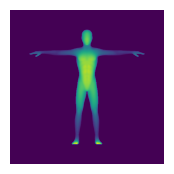

<Figure size 640x480 with 0 Axes>

In [17]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.camera_placement import front_facing_extrinsics
from text3d2video.utilities.image_utils import Affine2D
from text3d2video.utilities.ipython_utils import display_ims
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import FoVOrthographicCameras

from text3d2video.utilities.mesh_processing import normalize_meshes

animation = AnimationArtifact.from_wandb_artifact_tag("handstand:latest")
verts_uvs, faces_uvs = animation.uv_data()

meshes = load_objs_as_meshes(["data/meshes/mixamo-human.obj"]).to(device)
meshes = normalize_meshes(meshes)

R, T = front_facing_extrinsics()
s = 1.5

cams = FoVOrthographicCameras(R=R, T=T, device=device, scale_xyz=[(s, s, s)])
meshes = meshes.extend(len(cams))

depth_map = render_depth_map(meshes, cams)[0]

display_ims([depth_map])

In [18]:
from text3d2video.generative_rendering.extraction_injection_attn import (
    ExtractionInjectionAttn,
)

extraction_module_paths=[
    "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
]

controlnet_attn_processor = ExtractionInjectionAttn(
    controlnet,
    do_spatial_post_attn_extraction=False,
    do_spatial_qry_extraction=True,
    do_kv_extraction=True,
    attend_to_self_kv=False,
    feature_blend_alpha=1,
    extraction_attn_paths=extraction_module_paths,
    unet_chunk_size=1    
)

pipe.controlnet.set_attn_processor(controlnet_attn_processor)

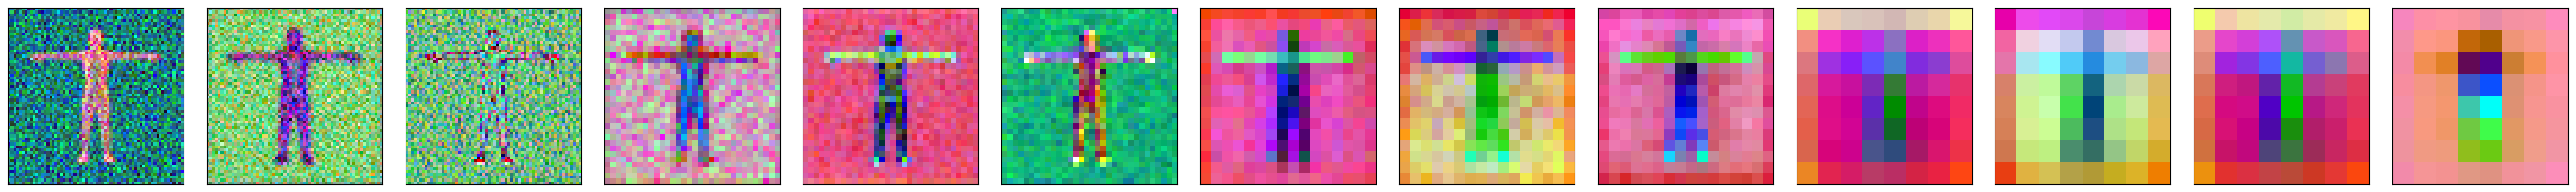

In [19]:
from text3d2video.utilities.ipython_utils import display_ims_grid, reduce_feature_maps


latents = torch.randn(1, 4, 64, 64).to(device).to(dtype)
t = torch.tensor(0)

cond_embeddings, uncond_embeddings = pipe.encode_prompt(["Deadpool"])

processed_ctrl_images = pipe.preprocess_controlnet_images([depth_map])

controlnet_attn_processor.set_extraction_mode()

src_down_residuals, src_mid_residual = pipe.controlnet(
    latents,
    t,
    encoder_hidden_states=cond_embeddings,
    controlnet_cond=processed_ctrl_images,
    return_dict=False,
)

pre_attn_features = controlnet_attn_processor.kv_features
spatial_features = controlnet_attn_processor.spatial_qry_features

src_residuals = src_down_residuals + [src_mid_residual]
display_ims_grid(reduce_feature_maps([[map[0] for map in src_residuals]]))

In [11]:
from text3d2video.backprojection import diffusion_dict_map
from text3d2video.utilities.ipython_utils import display_ims_grid

fun = Affine2D(angle=180)

warped_post_attn_features = diffusion_dict_map(spatial_features, lambda x, _: fun(x))

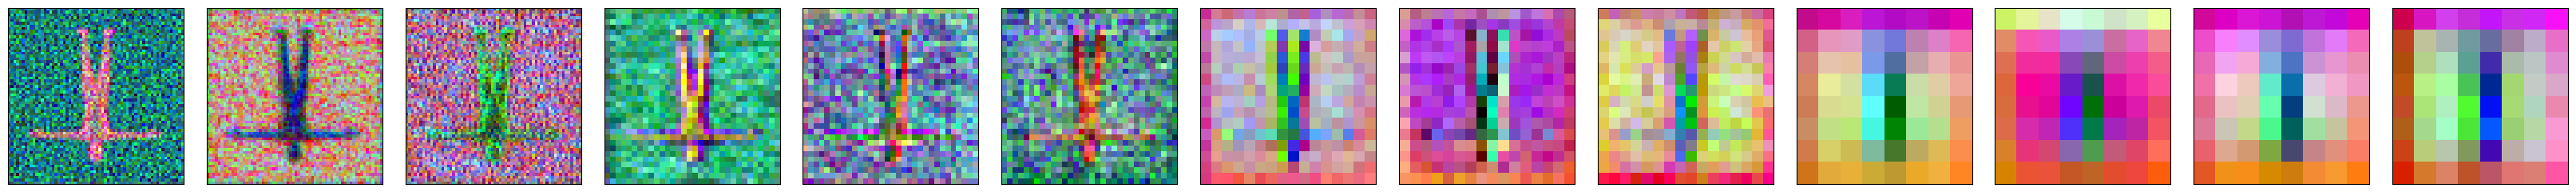

In [12]:
# attn_processor.set_injection_mode(pre_attn_features, rendered_features)
controlnet_attn_processor.set_injection_mode(pre_attn_features, warped_post_attn_features)
# controlnet_attn_processor.set_injection_mode({}, {})

processed_ctrl_images = pipe.preprocess_controlnet_images([fun(depth_map)])

tgt_down_residuals, tgt_mid_residual = pipe.controlnet(
    latents,
    t,
    encoder_hidden_states=cond_embeddings,
    controlnet_cond=processed_ctrl_images,
    return_dict=False,
)

tgt_residuals = tgt_down_residuals + [tgt_mid_residual]
display_ims_grid(reduce_feature_maps([[map[0] for map in tgt_residuals]]))

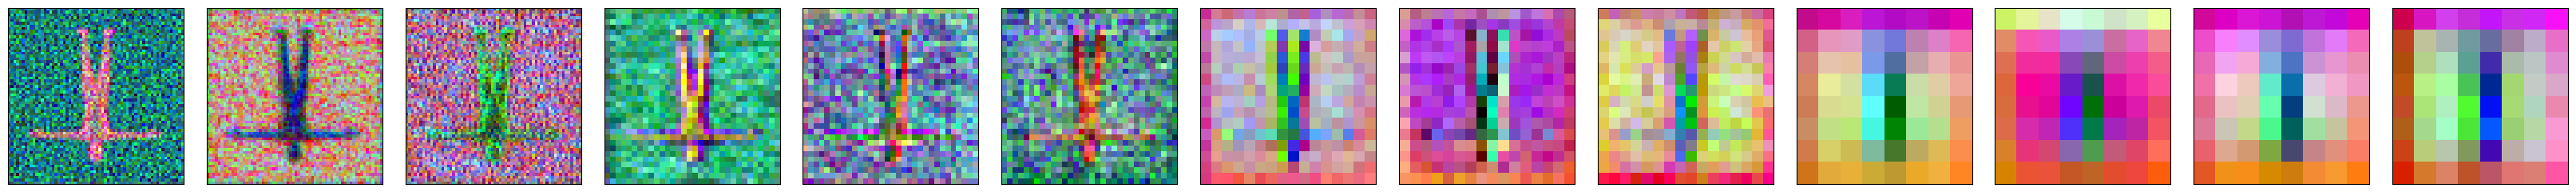

In [13]:
fmaps_tgt = [map[0] for map in tgt_residuals]
fmaps = [fmaps_tgt]

display_ims_grid(reduce_feature_maps(fmaps))

## Experiment, validating "equivariance hypothesis"

In [14]:
from text3d2video.utilities.image_utils import affine, affine_inv


translations = [(0, 0), (0.1, 0.1), (-0.1, -0.1), (-0.3, 0.3), (0.3, -0.3)]
angles = [60, 90, 180, 250 ]
zooms = [0.8, 1.2]

forward_funs = []
inverse_funs = []
for translation in translations:
    forward_funs.append(lambda im, translation=translation: affine(im, translation=translation))
    inverse_funs.append(lambda im, translation=translation: affine_inv(im, translation=translation))

for zoom in zooms:
    forward_funs.append(lambda im, zoom=zoom: affine(im, scale=zoom))
    inverse_funs.append(lambda im, zoom=zoom: affine_inv(im, scale=zoom))

for angle in angles:
    forward_funs.append(lambda im, angle=angle: affine(im, angle=angle))
    inverse_funs.append(lambda im, angle=angle: affine_inv(im, angle=angle))


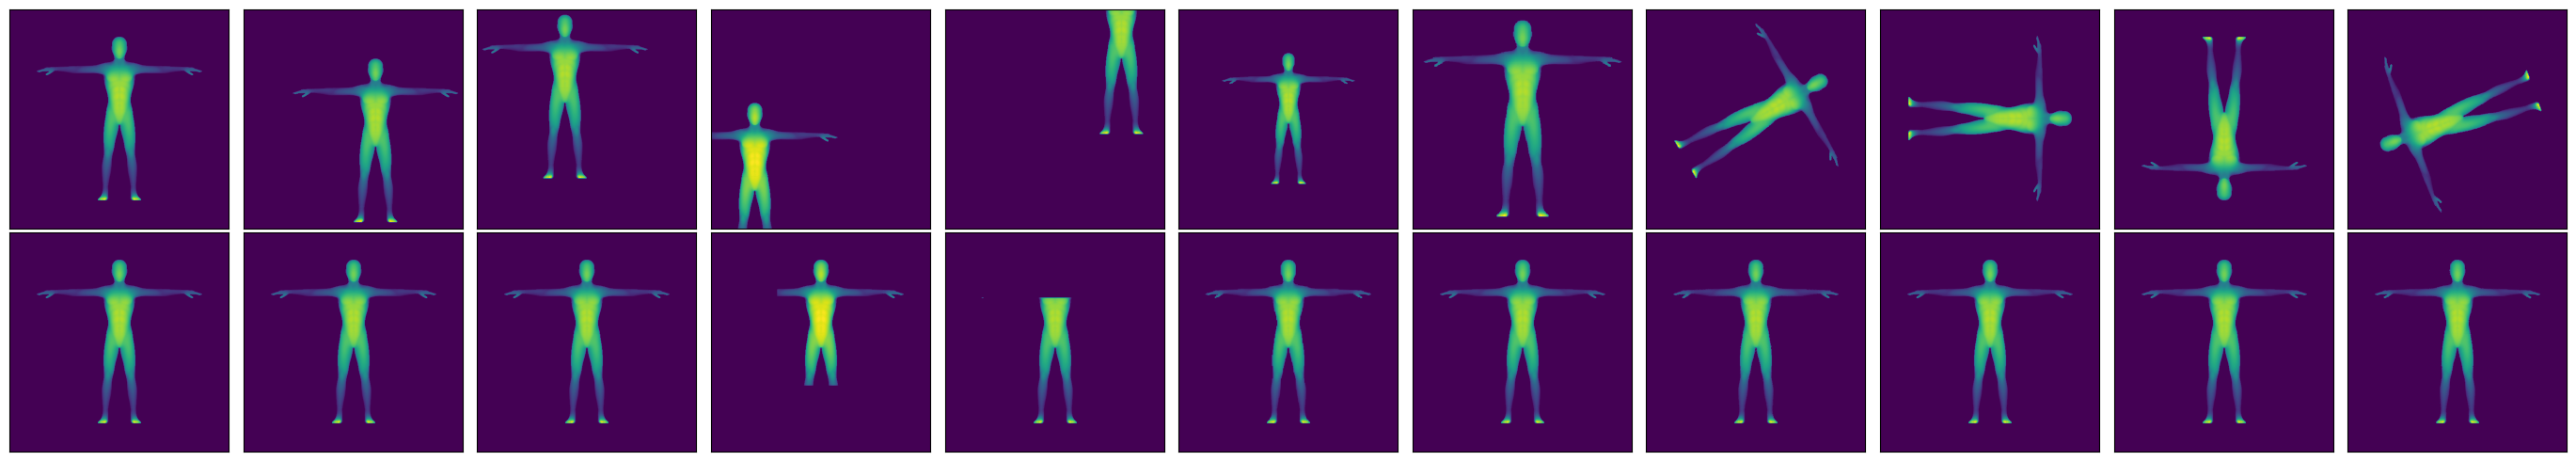

In [15]:
import torchvision.transforms.functional as TF

depth_maps = [f(TF.to_tensor(depth_map)) for f in forward_funs]
depth_maps = [TF.to_pil_image(x) for x in depth_maps]

depth_maps_aligned = [
    TF.to_pil_image(inv(TF.to_tensor(x))) for x, inv in zip(depth_maps, inverse_funs)
]

display_ims_grid([depth_maps, depth_maps_aligned])